In [1]:
import numpy as np
import skimage.io
import base64
import rpyc
import time
import os
import matplotlib.pyplot as plt
from glob import glob
import random
from skimage.transform import downscale_local_mean

In [6]:
# Test image location
image_test_list = glob('../BBBC022_v1_images_20585w1/*.tif')
print(image_test_list[0:3])

['../BBBC022_v1_images_20585w1/IXMtest_J13_s6_w1F0E650EC-2E3C-4C81-9FE7-8AFBB0B85C76.tif', '../BBBC022_v1_images_20585w1/IXMtest_O23_s4_w1449F027F-10F1-43AF-837E-E2E422F9BB88.tif', '../BBBC022_v1_images_20585w1/IXMtest_J20_s1_w1ADA15142-1D3F-453C-87B3-3926729F6258.tif']


260 347


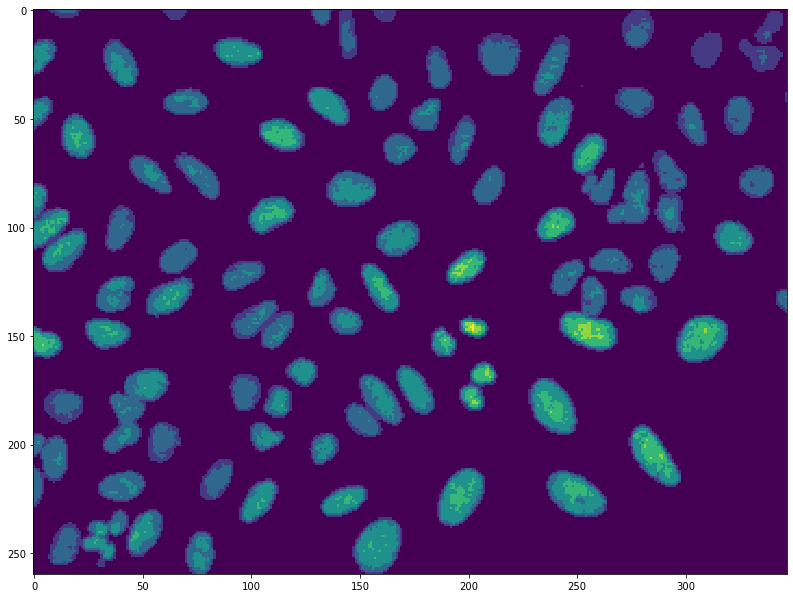

In [18]:
# Import random test image
image_test = random.choice(image_test_list)
np_pixels = skimage.io.imread(image_test)
np_pixels_downscaled = downscale_local_mean(np_pixels, (2, 2))
np_pixels_downscaled = (np_pixels_downscaled//256).astype('uint8')[:,1:]
height, width = np_pixels_downscaled.shape
print(height,width)
plt.figure(num=None, figsize=(13.5,11.5))
#skimage.io.imshow(normalize_image(np_pixels_downscaled))
plt.imshow(np_pixels_downscaled)
plt.show()

In [16]:
def normalize_image(img):
    
    if len(img.shape) == 2:
        
        percentile = 99.9
        high = np.percentile(img, percentile)
        low = np.percentile(img, 100-percentile)

        img = np.minimum(high, img)
        img = np.maximum(low, img)

        img = (img - low) / (high - low) # gives float64, thus cast to 8 bit later
        img = skimage.img_as_ubyte(img)

        # make a RGB-channel color image
        img_norm = np.stack([img, img, img], axis=-1)
        
    else:
        img_norm = np.zeros(img.shape, dtype='uint8')
        for ix in range(img.shape[2]):
            
            img_channel =  img[:,:,ix]
            percentile = 99.9
            high = np.percentile(img_channel, percentile)
            low = np.percentile(img_channel, 100-percentile)

            img_channel = np.minimum(high, img_channel)
            img_channel = np.maximum(low, img_channel)

            img_channel = (img_channel - low) / (high - low) # gives float64, thus cast to 8 bit later
            img_norm[:,:,ix] = skimage.img_as_ubyte(img_channel)
            
    return img_norm

In [17]:
def get_outputmask(image_name, output_mask):
    #....
    print("call back in client", image_name)

In [10]:
# Send to GPU server
start = time.time()
while True:
    try:
        conn = rpyc.connect("128.208.8.66", 18871)
        break
    except socket.timeout:
        print('Caught a timeout! Reconnecting...')
        time.sleep(2)
bgsrv = rpyc.BgServingThread(conn)
mon = conn.root.ImageAnalysis(get_outputmask)
b64_output_mask = mon.run_pipeline_on_image('test_img', base64.b64encode(np.ascontiguousarray(np_pixels_downscaled)))
np_output_mask = ((np.frombuffer(base64.decodebytes(b64_output_mask), np.uint8).reshape((height,width))).astype(np.uint8))
bgsrv.stop()
conn.close()
end = time.time()
print('Wall time: ' + str((end-start)*1000) + 'ms')

NameError: name 'socket' is not defined

In [ ]:
#Visualize both image and mask
plt.figure(num=None, figsize=(13.5,11.5))
skimage.io.imshow(normalize_image(np_pixels_downscaled))
plt.show()

plt.figure(num=None, figsize=(13.5,11.5))
skimage.io.imshow(np_output_mask)
plt.show()